In [54]:
import os, re
import numpy as np

In [9]:
# change to the root folder
base_dir = "/Users/jibanmac/Documents/GitHub/gpy_dla_detection/"
os.chdir(base_dir)

try:
    assert "null_gp.py" in os.listdir("gpy_dla_detection")
except Exception as e:
    print(e)
    print("[Warning] Change the directory of base_dir to the path of your gpy_dla_detection repository.")

In [10]:
# plotting styles
import matplotlib as mpl
from matplotlib import pyplot as plt

%matplotlib inline

mpl.rcParams['figure.dpi']= 150

# Tutorial: Automate Lyman alpha absorption detection 

In this tutorial, we will demonstrate how to use the Gaussian process code to detect Lyman alpha absorbers in the quasar spectra.

There are a few steps to understand how to use the GP code on quasar spectra, which we will go through step-by-step:
1. Understand Quasar Spectrum Data
2. Understand Voigt Profile
3. Understand how to use Bayesian model selection

## Understand Quasar Spectrum Data

A spectrum describes the number of photons (or the amount of light) we received from the astronomical object (in this case, quasar) at each wavelength.
Below we will download a spectrum from SDSS website, and use Python to plot the spectrum.

In [13]:
# The test selection file includes a list of 100 quasar spectra and their redshifts
from tests import test_selection
# The read spec module helps us to download and read the spectrum (for SDSS DR12 spectrum)
from gpy_dla_detection.read_spec import read_spec, retrieve_raw_spec

In [42]:
# take the first spectrum and download it
nspec = 51
filename = test_selection.filenames[nspec]
z_qso    = test_selection.z_qsos[nspec]

# If we haven't downloaded the file, this cell will help you download the file from SDSS database
if not os.path.exists(filename):
    # This line gets the plate, mjd, and fiber_id from the given filename
    # Note: re is the regex.
    plate, mjd, fiber_id = re.findall(
        r"spec-([0-9]+)-([0-9]+)-([0-9]+).fits", filename,
    )[0]
    # Download the file using the given plate, mjd, and fiber_id
    retrieve_raw_spec(int(plate), int(mjd), int(fiber_id))

# make sure the file exists
assert os.path.exists(filename) == True

[Info] retrieving https://data.sdss.org/sas/dr12/boss/spectro/redux/v5_7_0/spectra/4216/spec-4216-55477-0718.fits ... Done.


In [43]:
# Read the raw spectrum: This line reads the spectrum file into four numpy arrays
wavelengths, flux, noise_variance, pixel_mask = read_spec(filename)

* `wavelengths`: 1D float array. The observer-frame wavelengths of the quasar spectrum
* `flux`: 1D float array. The flux (photos per wavelength bin) of the quasar spectrum
* `noise_variance`: 1D float array. The instrumental noise variance of the flux.
* `pixel_mask`: 1D boolean array. The mask given by SDSS, which should be used to mask out undesired region of the spectrum.

Text(0, 0.5, 'Flux')

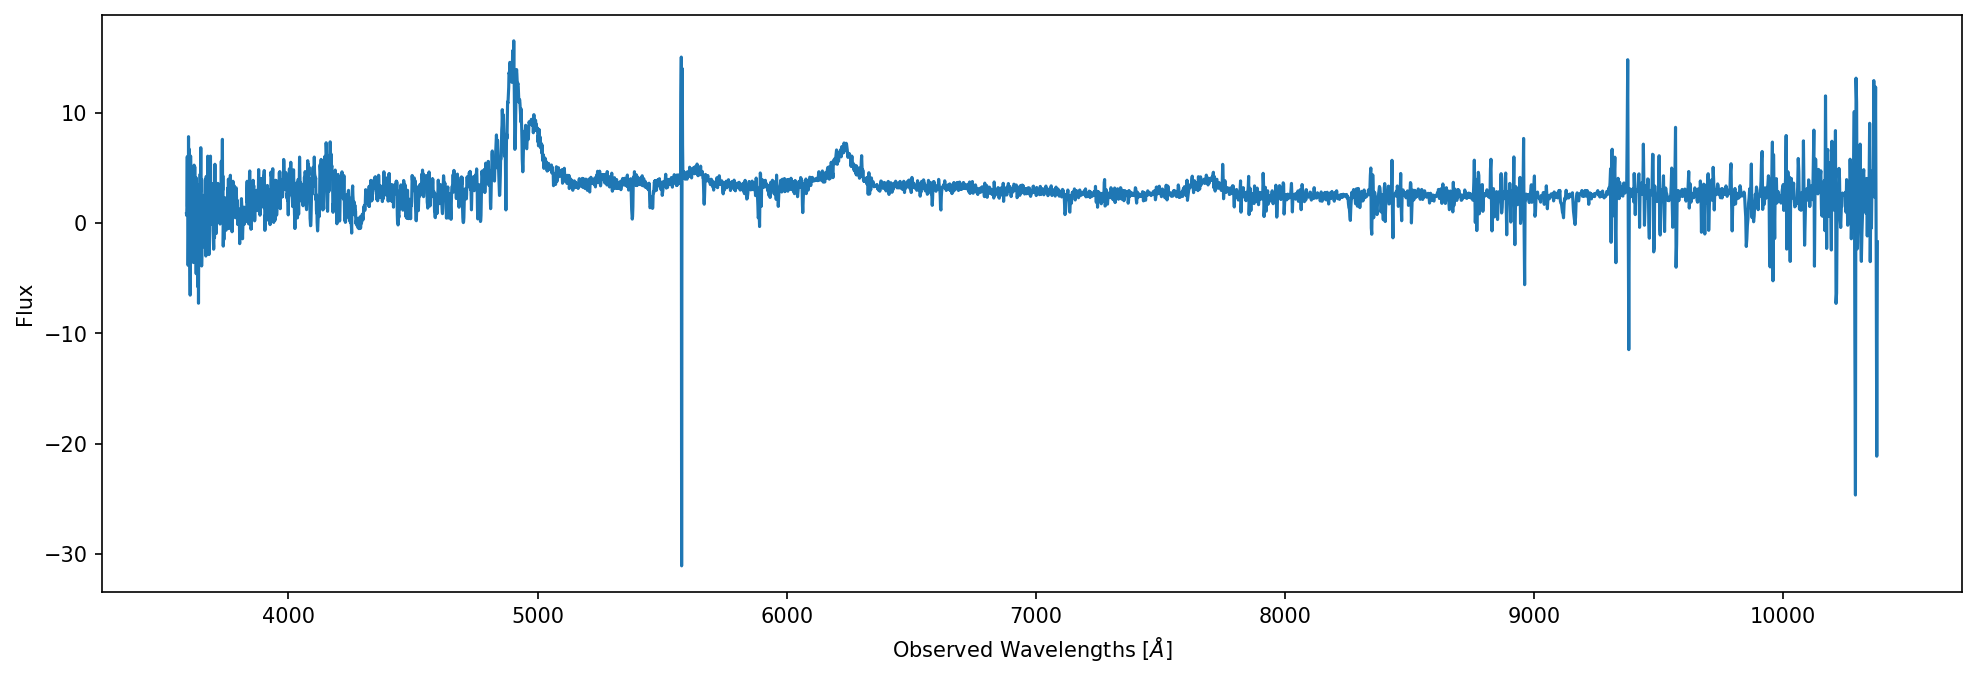

In [44]:
# plot it in "observed wavelengths"
plt.figure(figsize=(16, 5))
plt.plot(wavelengths, flux)
plt.xlabel("Observed Wavelengths [$\AA$]")
plt.ylabel("Flux")

Note that the **observed wavelengths** are redshifted, meaning they are stretched by the expansion of the Universe. The conversion of the observed wavelengths to the original wavelengths before redshifts is:

$$
\lambda_\mathrm{obs} = \lambda_\mathrm{rest} \times \frac{1}{a}
$$

$a$ is a number describes the size of the Universe, with a values $0 < a \leq 1$. At the current time, we have $a = 1$, so the observed wavelengths are the same as the original wavelegnths. We annotated the original wavelengths are $\lambda_\mathrm{rest}$, meaning the **rest wavelengths** or the wavelengths in the rest-frame.

$a$ is equal to $1/(1 + z)$, where $z$ is the redshift.

$$
\lambda_\mathrm{obs} = \lambda_\mathrm{rest} \times (1 + z)
$$

Below, we shift the observed wavelengths to rest-frame wavelengths, which is the wavelengths we see in the lab on the earth (no redshifted). It's a standard procedure for a quasar spectrum analysis to shift the observed wavelengths to rest-frame.

Text(0, 0.5, 'Flux')

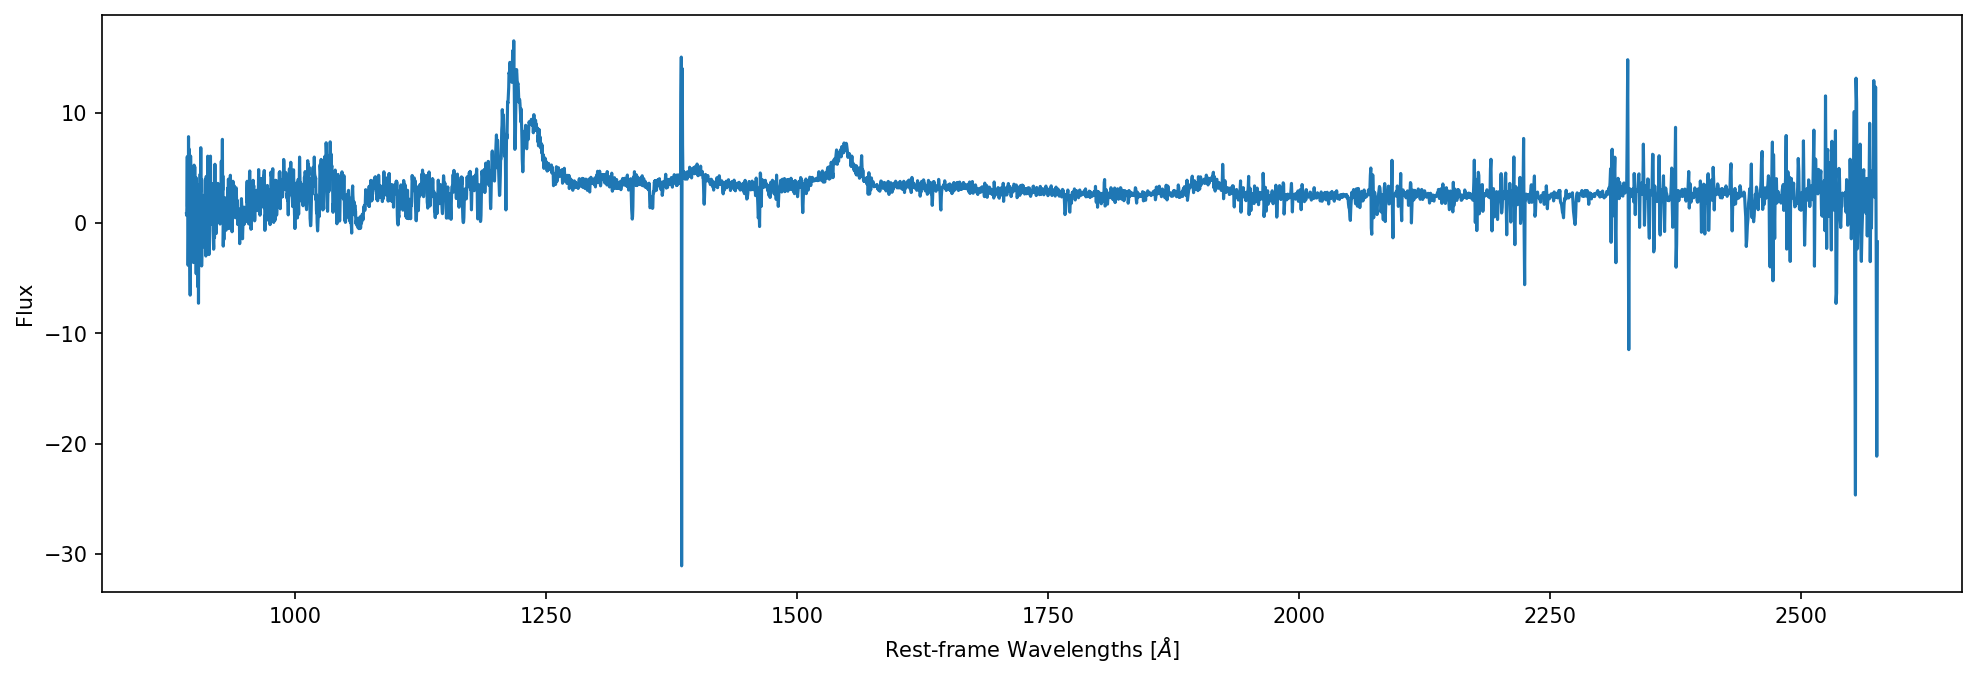

In [45]:
# plot it in "observed wavelengths"
rest_wavelengths = wavelengths / (1 + z_qso)

plt.figure(figsize=(16, 5))
plt.plot(rest_wavelengths, flux)
plt.xlabel("Rest-frame Wavelengths [$\AA$]")
plt.ylabel("Flux")

The blue line is a real quasar observation from Sloan Digital Sky Survey.
Why the line looks like there are lots of wiggles is because there is an uncertainty associated with each flux pixel in the spectrum.
The uncertainty is due to many reasons- exposure time is not enough, instrumental limitations, unknown sources.

We know there are several emission lines are usually in quasar spectrum. For example, 

| Rest-Wavelength | Emission Line |
| --- | --- |
| 1215.24 | $Ly\alpha$ (Lyman Alpha) |
| 1549.48 | CIV (Carbon Four)  |
| 2799.117 | MgII (Magnesium Two) |

See the detailed table in [here](https://classic.sdss.org/dr6/algorithms/linestable.html).

Let's label those lines in the spectrum:


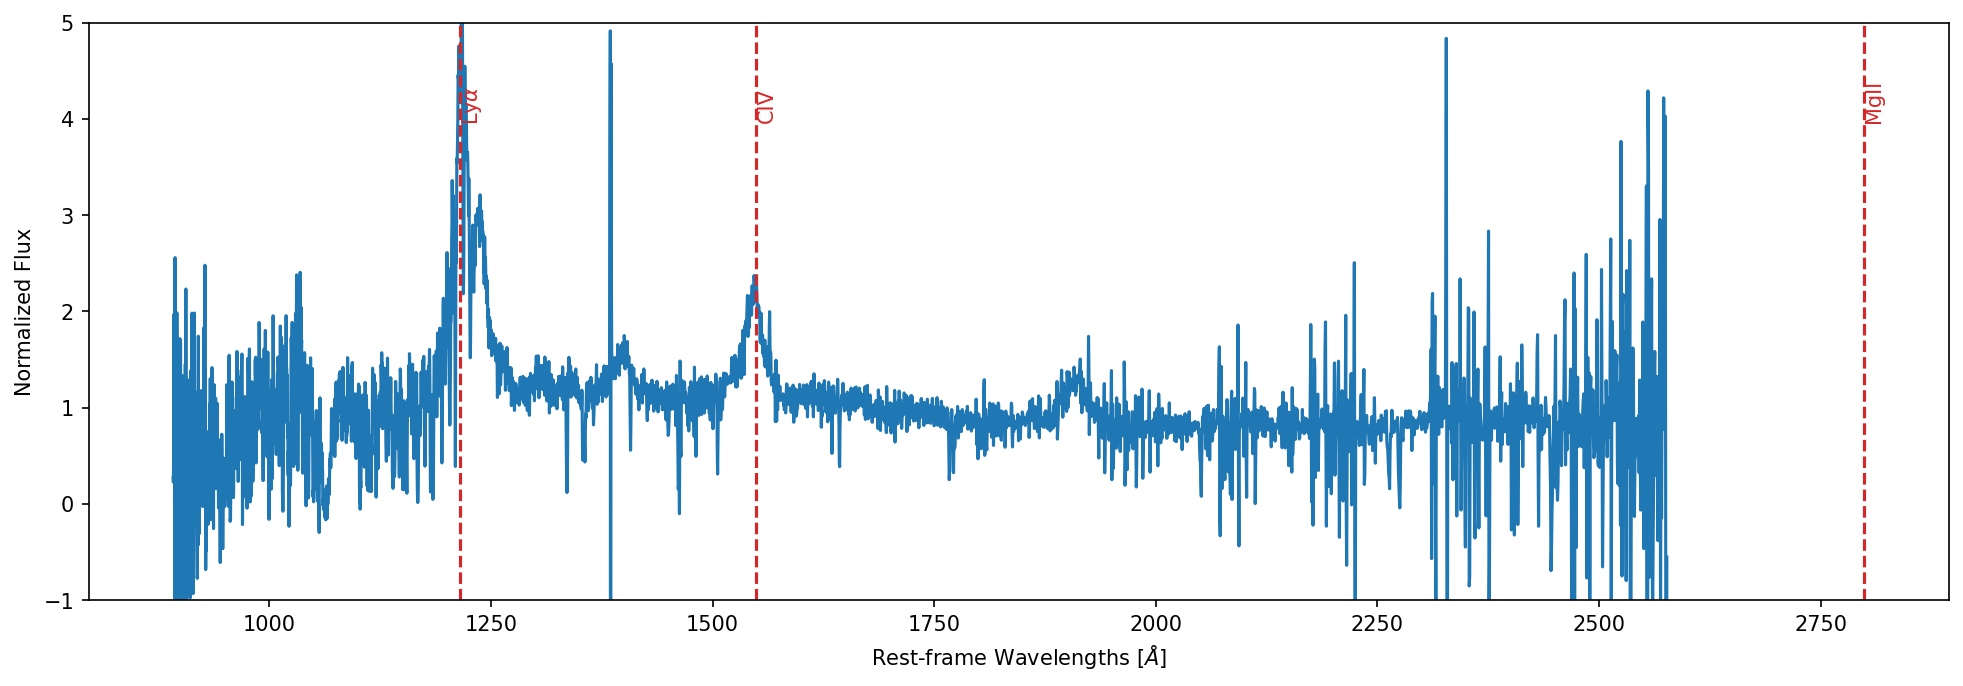

In [55]:
# Names and Rest-Wavelengths of the Emission Lines
emission_rest_wavelengths = [1215.24, 1549.48, 2799.117]
emission_names = [r"Ly$\alpha$", r"CIV", r"MgII"]

plt.figure(figsize=(16, 5))
plt.plot(rest_wavelengths, flux / np.mean(flux))
plt.xlabel("Rest-frame Wavelengths [$\AA$]")
plt.ylabel("Normalized Flux")
plt.ylim(-1, 5)

# plot the emission lines to help measure the z
for n, w in zip(emission_names, emission_rest_wavelengths):
    plt.vlines(w, -1, 5, color="C3", ls="--")
    plt.text(w, 4, n, rotation="vertical", color="C3")


For Lyman alpha absorptions, these absorptions will be in the rest-frame wavelengths $< 1216 \AA$:

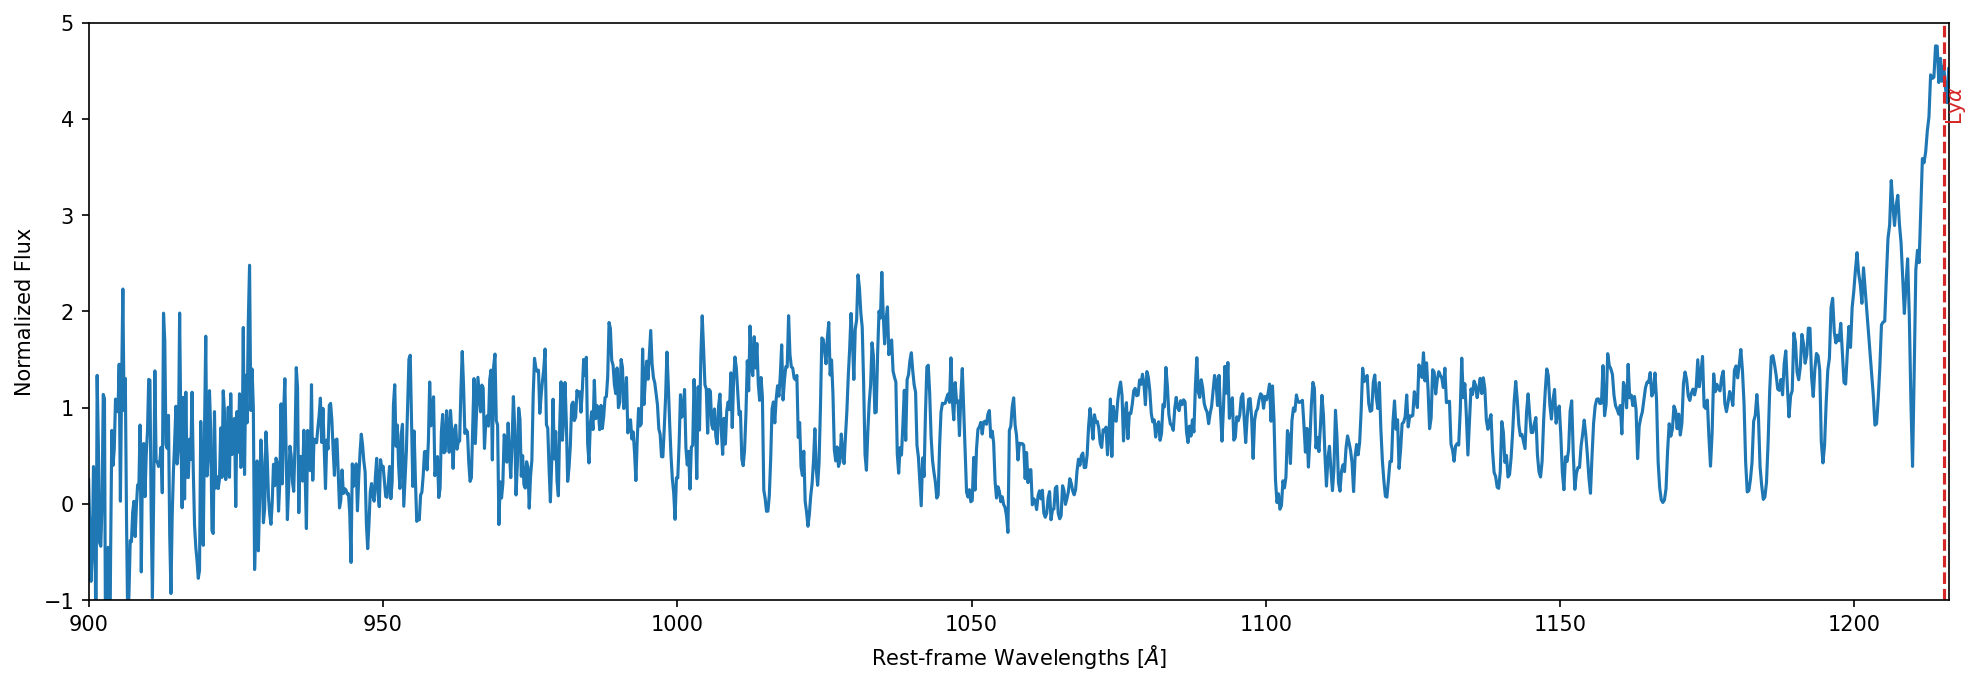

In [59]:
# Names and Rest-Wavelengths of the Emission Lines
emission_rest_wavelengths = [1215.24]
emission_names = [r"Ly$\alpha$"]

plt.figure(figsize=(16, 5))
plt.plot(rest_wavelengths, flux / np.mean(flux))
plt.xlabel("Rest-frame Wavelengths [$\AA$]")
plt.ylabel("Normalized Flux")
plt.ylim(-1 ,5)
plt.xlim(900, 1216)

# plot the emission lines to help measure the z
for n, w in zip(emission_names, emission_rest_wavelengths):
    plt.vlines(w, -1, 5, color="C3", ls="--")
    plt.text(w, 4, n, rotation="vertical", color="C3")


## Understand Voigt Profile

Voigt profile is a standard profile used by astronomers to model the absorption systems:
$$
\begin{equation}
   \begin{split}
      \phi(v, b, \gamma)
      &=\\
      \int \frac{d v}{\sqrt{2\pi}\sigma_v} &\exp{(-v^2 / 2\sigma_v^2)}
      \frac{4 \gamma_{\ell u}}{16 \pi^2 [ \nu - (1 - v/c)\nu_{\ell u} ]^2 + \gamma_{\ell u}^2},
   \end{split}
\end{equation}
$$
which is a convolution between a Lorenztian line profile and a Gaussian line profile.
The $\sigma_v$ is the one-dimensional velocity dispersion, $\gamma_{\ell u}$ is a parameter for Lorenztian profile, $\nu$ is the frequency, and $u$ represents the upper energy level and $\ell$ represents the lower energy level.

Both profiles are parameterised by the relative velocity $v$, which means both profiles are distributions in the 1-dimensional velocity space:
$$
\begin{equation}
   v = c \left( \frac{\lambda}{\lambda_{1u}} \frac{1}{(1 + z_\mathrm{absorber})} -1 \right).
\end{equation}
$$
The standard deviation of the Gaussian line profile is related to the broadening parameter $b = \sqrt{2} \sigma_v$, and if we assume the broadening is entirely due to thermal motion:
$$
\begin{equation}
   b = \sqrt{ \frac{2 k T}{m_p} }.
\end{equation}
$$
Introducing the damping constant $\Gamma  = 6.265 \times 10^8 \textrm{s}^{-1}$ for Lyman alpha, we have the parameter $\gamma_{\ell u}$ to describe the width of the Lorenztian profile
$$
\begin{equation}
   \gamma_{\ell u} = \frac{\Gamma \lambda_{\ell u}}{4\pi}.
\end{equation}
$$

We will use the `voigt.py`, which is a Voigt profile we've written for Lyman alpha absorptions, to demonstrate the voigt profile.